# 감성 분석 모델 평가하기

## 데이터 로드하기

In [1]:
import pandas as pd

In [2]:
df = pd.read_json("./conv_sent_test.jsonl", orient='record', lines=True)

In [3]:
df

,messages
0,"[{'role': 'system', 'content': '다음 대화의 내용에 대해 ..."
1,"[{'role': 'system', 'content': '다음 대화의 내용에 대해 ..."
2,"[{'role': 'system', 'content': '다음 대화의 내용에 대해 ..."
3,"[{'role': 'system', 'content': '다음 대화의 내용에 대해 ..."
4,"[{'role': 'system', 'content': '다음 대화의 내용에 대해 ..."


In [4]:
df.iloc[0]['messages']

[{'role': 'system', 'content': "다음 대화의 내용에 대해 '긍정' 또는 '부정'으로 감성 분석해줘."},
 {'role': 'user',
  'content': '철수: 안녕하세요? 평소에 어떤 취미로 시간을 보내세요?\n영희: 안녕하세요, 보통 책 읽거나 영화 보는 걸 좋아해요. 당신은요?\n철수: 저는 주로 운동을 좋아해요. 특히 등산이요.\n영희: 아, 저와는 잘 안 맞을 것 같네요. 저는 운동하는 걸 별로 좋아하지 않아서요.'},
 {'role': 'assistant', 'content': '부정'}]

In [5]:
df['conv_text'] = df.apply(lambda row: row['messages'][1]['content'], axis=1)

In [6]:
df['gold'] = df.apply(lambda row: row['messages'][2]['content'], axis=1)

In [7]:
df = df.drop(columns='messages')
df

,conv_text,gold
0,"철수: 안녕하세요? 평소에 어떤 취미로 시간을 보내세요?\n영희: 안녕하세요, 보통...",부정
1,"지훈: 안녕하세요, 지훈이라고 합니다. 취미로는 주로 사진 찍는 걸 좋아해요. 여러...",긍정
2,"지훈: 그래서, 너 평소에 무슨 취미로 시간 보내?\n혜수: 나? 음... 사실 별...",부정
3,"지훈: 안녕하세요, 손지훈입니다. 요즘에는 여가 시간에 뭐 하시나요?\n은지: 안녕...",긍정
4,"김민준: 요즘에는 무슨 취미로 시간을 보내세요?\n이하늘: 음, 그냥 집에서 푹 쉬...",부정


## Inference 해서 Prediction 만들기

In [8]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

In [11]:
infer_model = "ft:gpt-3.5-turbo-1106:personal::SOMETHING"

In [12]:
llm = ChatOpenAI(model=infer_model)

In [13]:
example_conv_text = """\
김민준: 안녕하세요, 처음 뵙겠습니다. 김민준이라고 해요.
이서연: 네, 안녕하세요. 이서연입니다. 
김민준: 요즘 어떻게 지내세요? 취미가 뭐에요?
이서연: 그냥 그래요. 별로 특별한 취미는 없고요, 여기 와서 할 이야기가 그게 전부인가요?
김민준: 아니, 그게... 좀 더 서로를 알아가는 과정이라 생각해서요.
이서연: 솔직히 말해서 여기 오는 것 자체가 별로였어요. 죄송하지만 저는 이만 가볼게요.
"""

In [14]:
sentiment_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "다음 대화의 내용에 대해 '긍정' 또는 '부정'으로 감성 분석해줘."),
        ("human", "{input}" )
    ]
)

In [15]:
sentiment_chain = sentiment_prompt_template | llm | StrOutputParser()

In [16]:
sentiment_chain.invoke({"input": example_conv_text})

'부정'

In [17]:
df['pred'] = df.apply(lambda row: sentiment_chain.invoke({"input": row['conv_text']}), axis=1) 

In [18]:
df

,conv_text,gold,pred
0,"철수: 안녕하세요? 평소에 어떤 취미로 시간을 보내세요?\n영희: 안녕하세요, 보통...",부정,부정
1,"지훈: 안녕하세요, 지훈이라고 합니다. 취미로는 주로 사진 찍는 걸 좋아해요. 여러...",긍정,긍정
2,"지훈: 그래서, 너 평소에 무슨 취미로 시간 보내?\n혜수: 나? 음... 사실 별...",부정,부정
3,"지훈: 안녕하세요, 손지훈입니다. 요즘에는 여가 시간에 뭐 하시나요?\n은지: 안녕...",긍정,긍정
4,"김민준: 요즘에는 무슨 취미로 시간을 보내세요?\n이하늘: 음, 그냥 집에서 푹 쉬...",부정,부정


## 평가하기

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns

In [20]:
y_true = [1 if sentiment == '긍정' else 0 for sentiment in df['gold']]
y_pred = [1 if sentiment == '긍정' else 0 for sentiment in df['pred']]  # 예측 레이블

In [21]:
y_true

[0, 1, 0, 1, 0]

In [22]:
y_pred

[0, 1, 0, 1, 0]

In [23]:
# 메트릭 계산
precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
accuracy = accuracy_score(y_true, y_pred)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred)

(precision, recall, accuracy, conf_matrix)

(1.0,
 1.0,
 1.0,
 array([[3, 0],
        [0, 2]]))

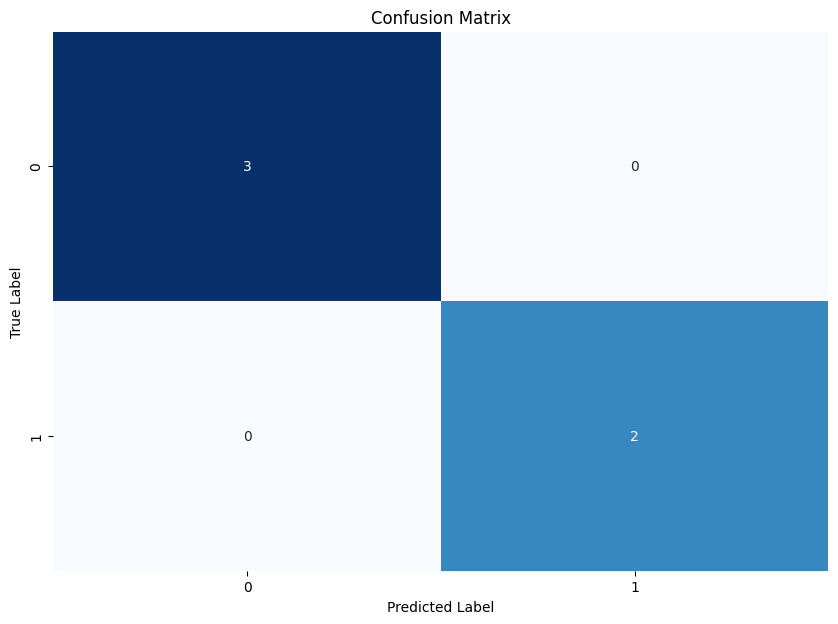

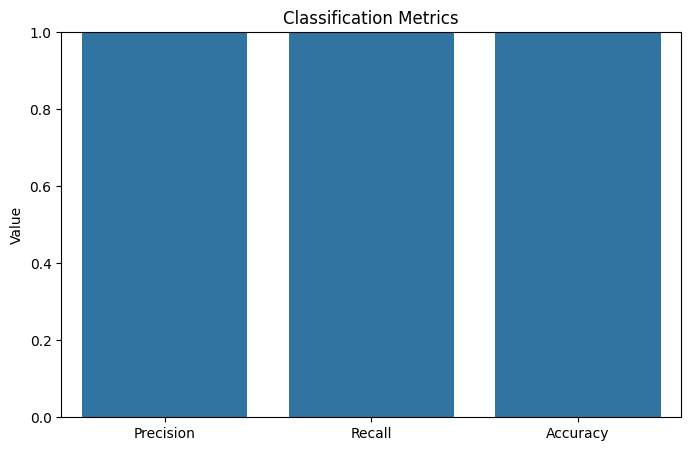

In [24]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 메트릭 시각화
metrics = ['Precision', 'Recall', 'Accuracy']
values = [precision, recall, accuracy]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.ylabel('Value')
plt.show()